In [ ]:
import pandas as pd
import numpy as np
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.utils import print_join_info

task = get_param_in_cwd('task_column') or 'label'
p_value = get_param_in_cwd('p_value') or 0.05
test_data = pd.read_csv(get_param_in_cwd('clinic_file'))
stats_columns_settings = get_param_in_cwd('stats_columns')
continuous_columns_settings = get_param_in_cwd('continuous_columns')
mapping_columns_settings = get_param_in_cwd('mapping_columns')
test_data = test_data[[c for c in test_data.columns if c != task]]
group_info = pd.read_csv(get_param_in_cwd('label_file'))
print_join_info(test_data, group_info)
test_data = pd.merge(test_data, group_info, on='ID', how='inner')
test_data

In [3]:
import re

def map_cnames(x):
    x = re.split('[（|(]', x)[0]
    x = x.replace('-', '_').replace(' ', '_').replace('>', '').replace('/', '_')
    return x.strip()

test_data.columns = list(map(map_cnames, test_data.columns))
test_data.columns

Index(['ID', 'ki67', 'Age', 'label', 'group'], dtype='object')

In [4]:
stats_columns = [c for c in stats_columns_settings or list(test_data.columns[1:-2])]
test_data = test_data.copy()[['ID'] + stats_columns + ['group', 'label']]
test_data

,ID,ki67,Age,group,label
0,2013-00480,0.30,53,train,1
1,2013-00618,0.80,48,train,0
2,2013-01131,0.70,47,train,0
3,2013-01345,0.10,69,train,1
4,2013-02436,0.60,68,train,0
...,...,...,...,...,...
199,2014-49166,0.10,59,train,1
200,2014-49281,0.20,44,train,1
201,2014-49849,0.20,48,test,1
202,2014-49850,0.08,33,test,1


In [5]:
mapping_columns = mapping_columns_settings or [c for c in test_data.columns[1:-2] if test_data[c].dtype == object]
mapping_columns

[]

In [6]:
from onekey_algo.custom.utils import map2numerical

data, mapping = map2numerical(test_data, mapping_columns=mapping_columns)
mapping

{}

In [7]:
from onekey_algo.custom.components.comp1 import fillna

test_data = fillna(test_data, fill_mod='50%')
continuous_columns = []
for col in test_data.columns:
    if test_data[col].apply(lambda x: x.is_integer() if isinstance(x, float) else False).all():
        test_data[col] = test_data[col].astype(int)

for c in stats_columns:
#     print(c, np.unique(test_data[c]), test_data[c].dtype)
    if len(np.unique(test_data[c])) > 5 or not np.int8 <= test_data[c].dtype <= np.int64:
        continuous_columns.append(c)
        
continuous_columns = continuous_columns_settings or continuous_columns
continuous_columns = [c for c in continuous_columns if c not in ('differentation')]
continuous_columns

['ki67', 'Age']

In [8]:
import os
os.makedirs('data', exist_ok=True)
data = test_data
data.to_csv('data/clinical.csv', index=False)
data

,ID,ki67,Age,group,label
0,2013-00480,0.30,53,train,1
1,2013-00618,0.80,48,train,0
2,2013-01131,0.70,47,train,0
3,2013-01345,0.10,69,train,1
4,2013-02436,0.60,68,train,0
...,...,...,...,...,...
199,2014-49166,0.10,59,train,1
200,2014-49281,0.20,44,train,1
201,2014-49849,0.20,48,test,1
202,2014-49850,0.08,33,test,1


In [9]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column='group', 
                     group_column=None, 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv('stats.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,-label=ALL,-label=test,-label=train,pvalue
0,ki67,0.28±0.22,0.27±0.20,0.29±0.24,0.955
1,Age,52.71±10.60,52.32±9.71,52.88±11.00,0.862


,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
ki67,-0.77,-1.036,-0.504,0.463,0.355,0.604,0.000
Age,-0.00,-0.006,0.006,1.000,0.994,1.006,0.959


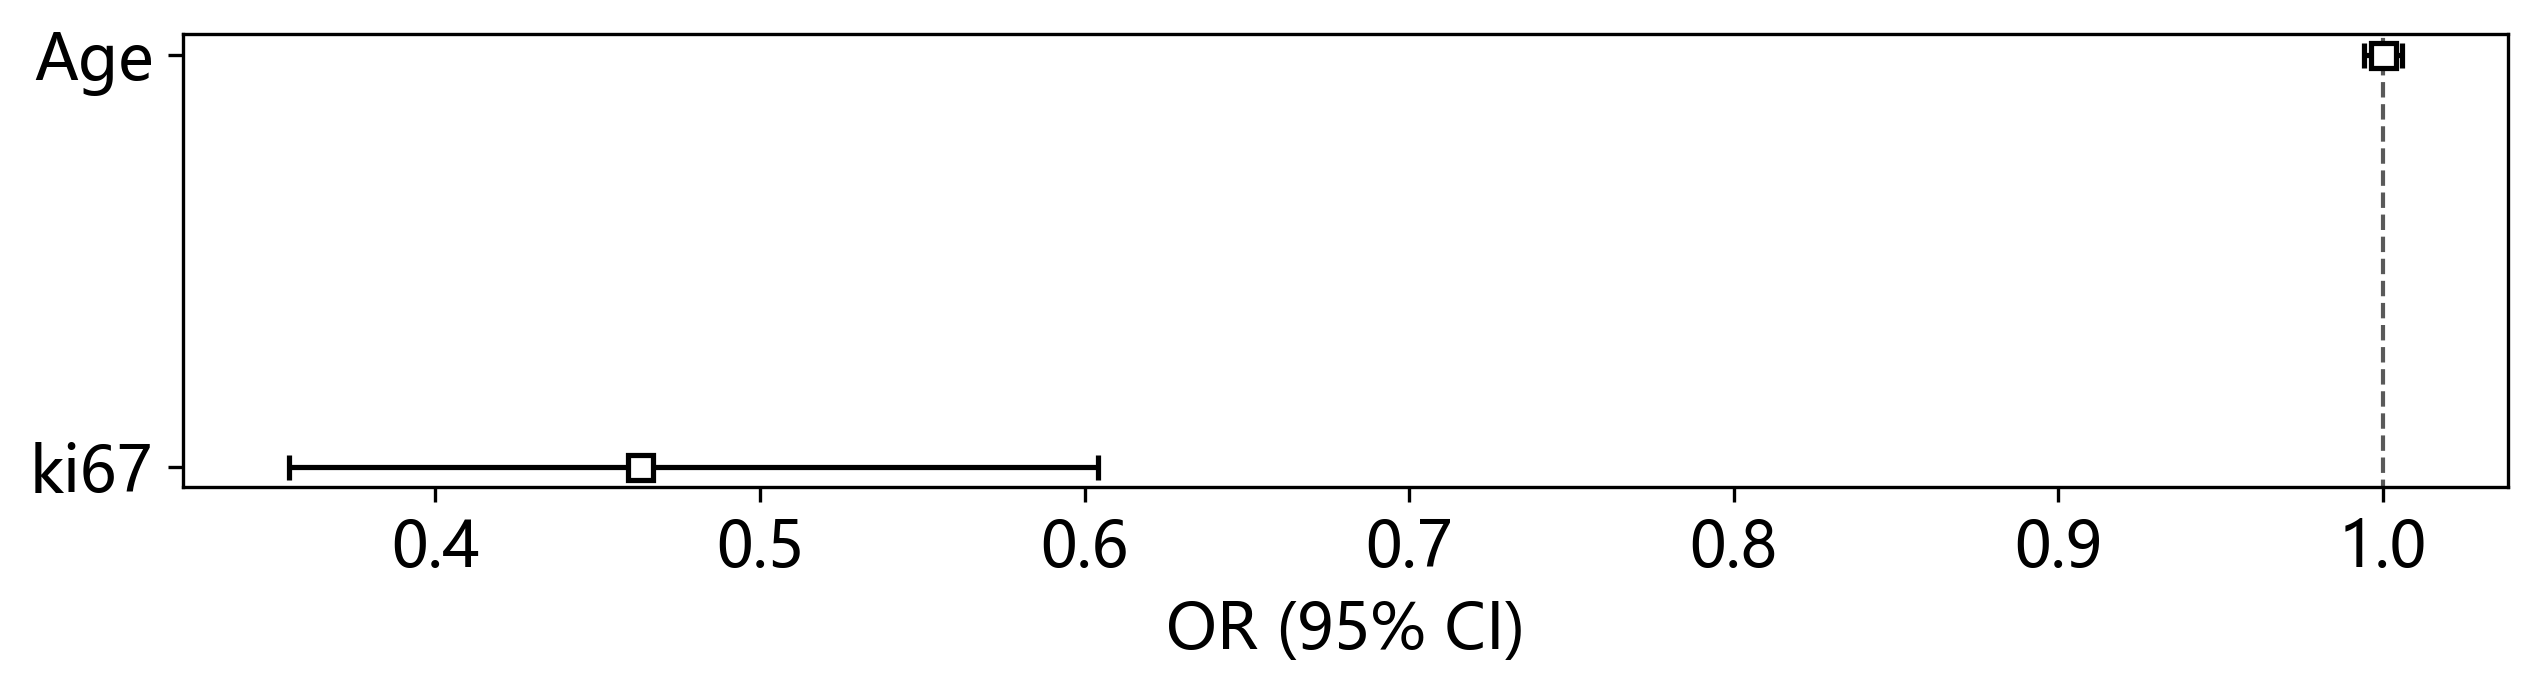

,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
ki67,-0.77,-1.036,-0.504,0.463,0.355,0.604,0.0


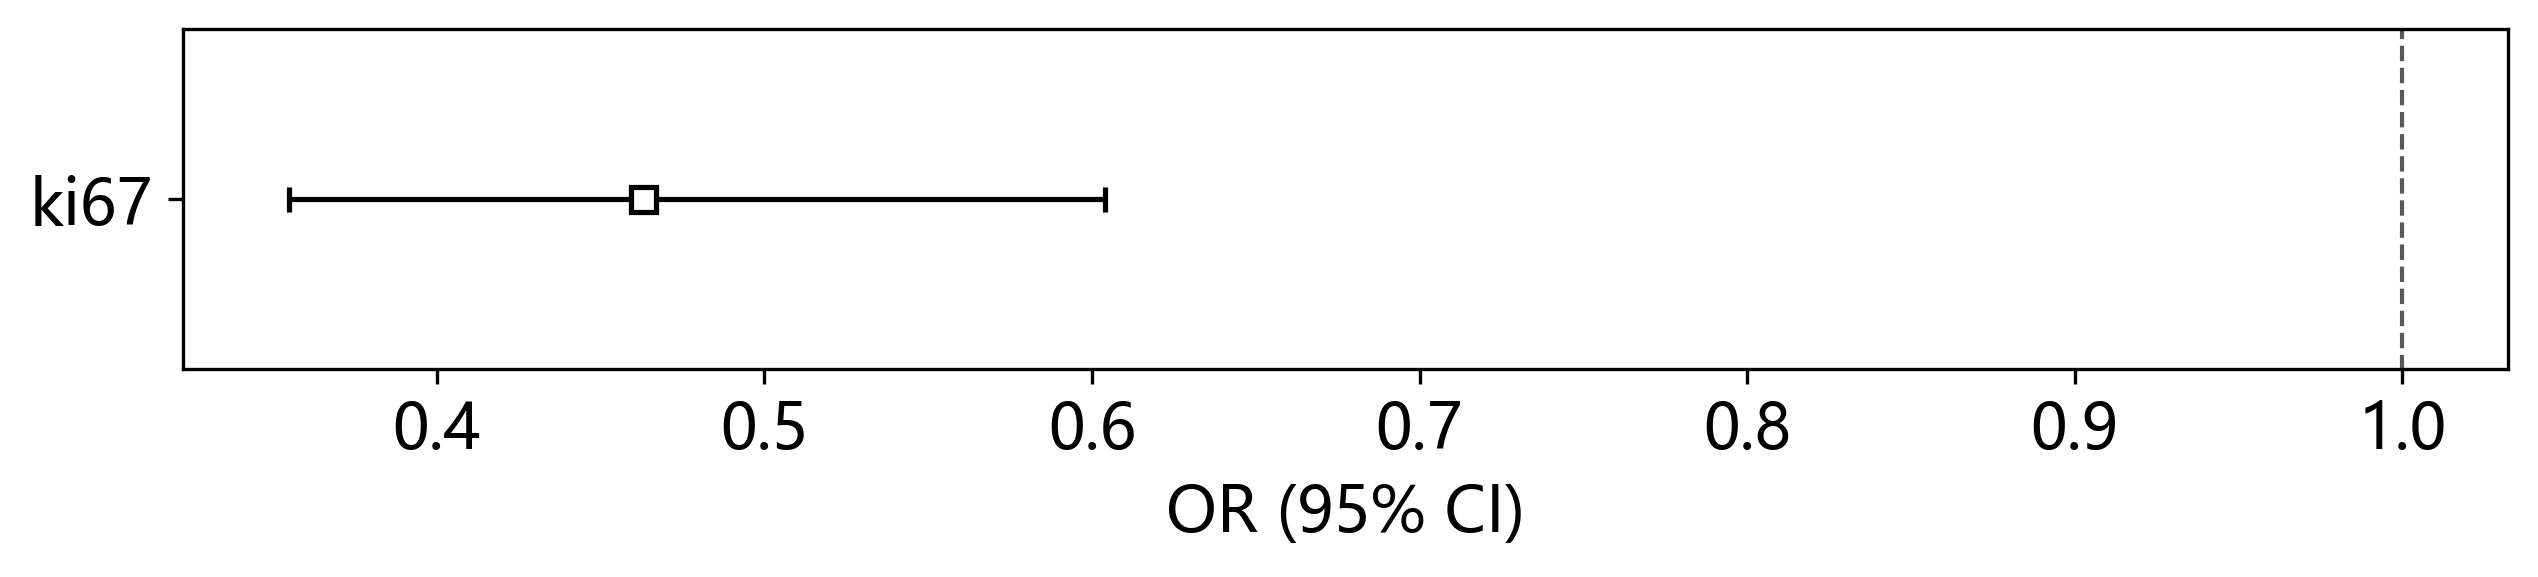

In [10]:
from onekey_algo.custom.components.comp1 import uni_multi_variable_analysis                        

r = uni_multi_variable_analysis(data[data['group'] == 'train'], stats_columns, save_dir='img', p_value4multi=p_value, hazard_ratios=True)

In [11]:
uni_v = pd.read_csv('img/multivariable_reg.csv')
uni_v = uni_v[uni_v['p_value'] <= 0.05]
sel_data = data[['ID'] + list(uni_v['feature_name']) + ['group', 'label']]
sel_data.to_csv('clinic_sel.csv', index=False)
sel_data

,ID,ki67,group,label
0,2013-00480,0.30,train,1
1,2013-00618,0.80,train,0
2,2013-01131,0.70,train,0
3,2013-01345,0.10,train,1
4,2013-02436,0.60,train,0
5,2013-03703,0.70,test,0
6,2013-03710,0.20,train,1
7,2013-04197,0.70,train,0
8,2013-05187,0.40,test,0
9,2013-05470,0.30,train,1


In [12]:
uni = pd.read_csv('img/univariable_reg.csv')
uni = uni[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
multi = pd.read_csv('img/multivariable_reg.csv')
multi = multi[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
pd.merge(uni, multi,
         on='feature_name', how='left', suffixes=['_UNI', '_MULTI']).applymap(lambda x: '' if pd.isna(x) else x)

,feature_name,OR_UNI,OR lower 95%CI_UNI,OR upper 95%CI_UNI,p_value_UNI,OR_MULTI,OR lower 95%CI_MULTI,OR upper 95%CI_MULTI,p_value_MULTI
0,ki67,0.463,0.355,0.604,0.000,0.463,0.355,0.604,0.0
1,Age,1.000,0.994,1.006,0.959,,,,
